In [ ]:
# trying to use the same idea from mlTests03, but this time actually understand what I'm doing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# settings
model_settings = {'epochs': 100, 'batch_size': 4, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'start_date': '2020-01-01', 'n_steps_in': 3, 'n_steps_out': 2, 'symbol': 'CTXR'}
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# load and shape data
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{model_settings['symbol']}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])
df = df.reset_index()

df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[model_settings['start_date']:current_date]  # date range from 2019-01-01 to 2021-05-31

close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)
columns = [i for i in close_df.columns]
close_df

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-02,3.210,5.6800,0.0700,0.10000,2.94,3.790,0.7410,2.070,2.3800,0.280,...,0.75,1.3000,1.580,1.140,2.3400,4.6200,0.160,0.3310,1.5200,5.8800
2020-01-03,2.900,5.5600,0.0700,0.10000,3.08,3.580,0.7410,2.040,2.3300,0.280,...,0.75,1.4100,1.530,1.090,2.2700,4.5000,0.160,0.3320,1.5500,5.8100
2020-01-06,2.770,5.6300,0.0700,0.10000,3.18,3.690,0.7410,2.010,2.2100,0.280,...,0.75,1.4200,1.550,1.100,2.2200,4.4900,0.160,0.3130,1.6400,5.7000
2020-01-07,2.570,5.6700,0.0800,0.10000,3.04,3.710,0.7250,2.070,2.3300,0.240,...,0.75,1.4100,1.590,1.090,1.8400,4.5300,0.160,0.3130,1.7100,5.5600
2020-01-08,2.620,6.0700,0.0800,0.10000,3.07,3.690,0.7330,2.030,2.1900,0.240,...,0.75,1.2600,1.580,1.070,1.5900,4.5900,0.160,0.3200,1.6200,5.3100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1.710,3.4900,0.0636,0.07920,2.86,2.960,1.1180,1.430,0.5071,0.365,...,1.80,3.5400,1.450,4.600,2.9300,3.0700,4.255,0.8239,0.8025,5.0700
2021-06-02,1.745,3.5690,0.0645,0.11490,3.02,2.910,1.1400,1.440,0.5290,0.365,...,1.82,3.5500,1.488,4.650,3.1550,3.0400,4.145,0.8379,0.8006,5.2800
2021-06-03,1.825,3.7000,0.0631,0.07609,2.90,2.881,1.1400,1.445,0.5373,0.365,...,1.74,3.5242,1.660,4.645,3.1500,3.1400,4.290,1.0050,0.8069,5.1819


In [2]:
# scale the train/test data prior to splitting it
scaler = MinMaxScaler(feature_range=(0,1))
scaler_single = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_df.values)
single_data = close_df[model_settings['symbol']].to_frame()     # may not be the right want to do this; may need to only use the split amt of data
scaled_data_single = scaler_single.fit_transform(single_data.values)

In [3]:
# this cell does not add new dates to the end, try that later
# splitting test/training data

# close_df = close_df.reset_index()

data_size = len(scaled_data)

# using a 90/10 train/test split
training_data = scaled_data[:(int(data_size * .7))]
test_data = scaled_data[(int(data_size * .7)):]
training_data_df = close_df[:(int(data_size * .7))]
test_data_df = close_df[(int(data_size * .7)):]

In [8]:
# ignore for now
# splitting test/training data

# close_df = close_df.reset_index()

data_size = len(scaled_data)

# using a 90/10 train/test split
training_data = scaled_data[:(int(data_size * .7))]
test_data = scaled_data[(int(data_size * .7)):]
training_data_df = close_df[:(int(data_size * .7))]
test_data_df = close_df[(int(data_size * .7)):]

# add some extra dates to end of test_data_df
# calc two weeks from todays date;llllllllll54hg8=[-]
today = datetime.datetime.now()
future = datetime.timedelta(days=14)
two_weeks_from_date = today + future

test_data_df = test_data_df.reset_index()

future_dates = []

# for now, -2 b/c of my data
for date in range (-2, 30):
    future = datetime.timedelta(days=date)
    future = today + future
    if future.weekday() in [5,6]:
        continue
    future = future.strftime('%Y-%m-%d')
    future = pd.to_datetime(future, format='%Y-%m-%d')
    future_dates.append({'price_datetime': future})

test_data_df = test_data_df.append(future_dates, ignore_index=True)

test_data_df = test_data_df.set_index('price_datetime')

# this value may need to change, i'm not sure
test_data_df = test_data_df[-24:-1]

test_data_df.tail(50)

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2021-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# I think I understand this now
# n_lags is used for setting the window of values to look at at once (like set sequences in the other example)
# so we look at values 0-n_lags at first iteration, add those to X_train, and add the actual value after n_lags to y_train
# I may reduce the window of 60, it's a lot for a small time window that I'm using.
# train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, training_data.shape[0]):
    X_train.append(training_data[i-n_lags:i])
    y_train.append(training_data[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
# reshape data to the proper form for LSTM (samples, timesteps (60 normal), features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

In [5]:
# check shapes
X_train.shape, y_train.shape

((191, 60, 412), (191,))

In [6]:
# compile model...
# LSTM architecture
model = Sequential()

# First layer, w/ dropout regularization
# input shape is timesteps, features?
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))

# Third
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.5))

# Fourth
model.add(LSTM(units=20))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=1))

# Compile LSTM
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# train model
# looking at this, I'm not so sure that this is working in the most efficient and helpful manner. May try some other methods in the future
# ala https://stackoverflow.com/questions/50448743/is-it-logical-to-loop-on-model-fit-in-keras
# Fit to Training set
# fit to training set
num_features = len(columns)
progress = 1
for i in columns:
    print("Fitting to", i)
    print("Training feature", progress, "of", num_features)
    model.fit(X_train, y_train, epochs=2, batch_size=32, verbose=0)
    progress += 1

Fitting to ABEO
Training feature 1 of 412
Fitting to ABIO
Training feature 2 of 412
Fitting to ABMC
Training feature 3 of 412
Fitting to ABMT
Training feature 4 of 412
Fitting to ABUS
Training feature 5 of 412
Fitting to ACER
Training feature 6 of 412
Fitting to ACHFF
Training feature 7 of 412
Fitting to ACRX
Training feature 8 of 412
Fitting to ACST
Training feature 9 of 412
Fitting to ACUR
Training feature 10 of 412
Fitting to ADIL
Training feature 11 of 412
Fitting to ADMA
Training feature 12 of 412
Fitting to ADMP
Training feature 13 of 412
Fitting to ADMS
Training feature 14 of 412
Fitting to ADMT
Training feature 15 of 412
Fitting to ADXS
Training feature 16 of 412
Fitting to AEMD
Training feature 17 of 412
Fitting to AEZS
Training feature 18 of 412
Fitting to AGE
Training feature 19 of 412
Fitting to AGEN
Training feature 20 of 412
Fitting to AGRX
Training feature 21 of 412
Fitting to AGTC
Training feature 22 of 412
Fitting to AHPI
Training feature 23 of 412
Fitting to AIKI
Trai

In [16]:
# using their code for test data, just so that the indicies align for prediction vs test...
total_data = np.concatenate((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - 60:]
# inputs = data[len(data) - len(test_data) - 60:]

# predicted_input = inputs[symbol].to_frame()
# inputs = inputs.drop(columns=symbol)

# test_scaled = np.concatenate([minmax.transform(inputs), minmax_single.transform(predicted_input)], axis=1)
# print('Shape of test data:', test_scaled.shape)

# shaping test data from neural network
X_test = []
y_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-n_lags:i])
    y_test.append(inputs[i,0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], -1))

In [18]:
# see what happens when you feed the model the training data set?
prediction = model.predict(X_test)
prediction = scaler_single.inverse_transform(prediction)
prediction = pd.DataFrame(prediction)
prediction.rename(columns = {0: f'{model_settings["symbol"]}_predicted'}, inplace=True)
prediction.index = test_data_df.index

In [19]:
prediction

,CTXR_predicted
price_datetime,
2020-12-30,0.874624
2020-12-31,0.870154
2021-01-04,0.866279
2021-01-05,0.863834
2021-01-06,0.862998
...,...
2021-06-01,1.038337
2021-06-02,1.038411
2021-06-03,1.038415


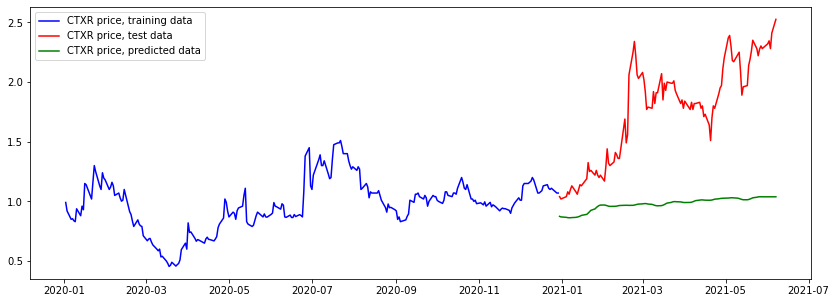

In [21]:
# test data output
plt.figure(figsize=(14,5))
plt.plot(training_data_df[model_settings['symbol']], color='blue', label=f"{model_settings['symbol']} price, training data")
plt.plot(test_data_df[model_settings['symbol']], color='red', label=f"{model_settings['symbol']} price, test data")
plt.plot(prediction[f"{model_settings['symbol']}_predicted"], color='green', label=f"{model_settings['symbol']} price, predicted data")
plt.legend()

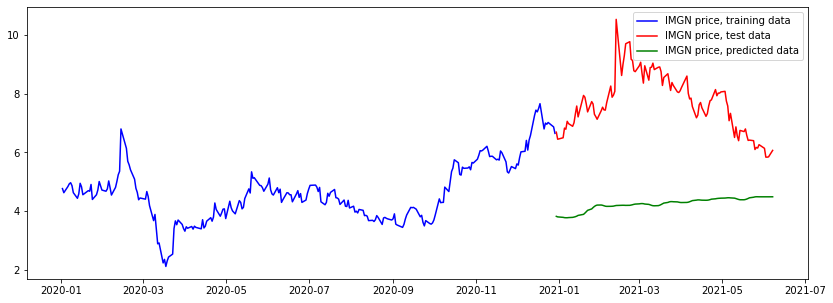

In [22]:
# attempt to predict
# based on earlier code
# tbh, I don't think this will work?
test_symbol = 'IMGN'
single_data = close_df[test_symbol].to_frame()
scaled_data_single = scaler_single.fit_transform(single_data.values)

prediction = model.predict(X_test)
prediction = scaler_single.inverse_transform(prediction)
prediction = pd.DataFrame(prediction)
prediction.rename(columns = {0: f'{test_symbol}_predicted'}, inplace=True)
prediction.index = test_data_df.index

plt.figure(figsize=(14,5))
plt.plot(training_data_df[test_symbol], color='blue', label=f"{test_symbol} price, training data")
plt.plot(test_data_df[test_symbol], color='red', label=f"{test_symbol} price, test data")
plt.plot(prediction[f"{test_symbol}_predicted"], color='green', label=f"{test_symbol} price, predicted data")
plt.legend()

# New start down here
Going to try making a univariate multi-step forecasting model,just train the model on all of the ticker symbols.

If this works well, I am going to delete all of the above cells, as I'm tired of making new notebooks to try different things.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import datetime
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler



# settings
model_settings = {'epochs': 2, 'batch_size': 32, 'train_test_ratio': 0.7, 'hidden_layers': 3, 'units': 100, 'start_date': '2020-01-01', 'n_steps_in': 14, 'n_steps_out': 30, 'symbol': 'CTXR'}
current_date = datetime.datetime.now().strftime("%Y-%m-%d")

# load and shape data
conn = sqlite3.connect('stockPrediction_06072021.db')

symbol_info = conn.execute(f"SELECT sector_id, industry_id FROM stock WHERE stock_symbol = \"{model_settings['symbol']}\";")
symbol_info = symbol_info.fetchall()
sector_id = symbol_info[0][0]
industry_id = symbol_info[0][1]

query = f"SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM eod_price_history l INNER JOIN stock r ON r.stock_id = l.stock_id WHERE r.sector_id = {sector_id} OR r.industry_id = {industry_id};"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])
df = df.reset_index()

df['price_datetime'] = pd.to_datetime(df['price_datetime'], format='%Y-%m-%d')

df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])

df = df.loc[model_settings['start_date']:current_date]  # date range from 2019-01-01 to 2021-05-31

close_df = df['close_price'].dropna(thresh=(len(df['close_price'] / 0.2)), axis=1)

close_df = close_df.fillna(method='ffill', axis=1)

# remove outliers
low_outlier = close_df.quantile(.1, axis=1).quantile(.1)
high_outlier = close_df.quantile(.9, axis=1).quantile(.9)
for column in close_df.columns:
    if (close_df[column].median() < low_outlier) or (close_df[column].median() > high_outlier):
        close_df = close_df.drop([column], axis=1)
columns = [i for i in close_df.columns]
close_df

stock_symbol,ABEO,ABIO,ABMC,ABMT,ABUS,ACER,ACHFF,ACRX,ACST,ACUR,...,XPHYF,XTLB,XTNT,XXII,YCBD,ZIOP,ZIVO,ZOM,ZSAN,ZYNE
price_datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-02,3.210,5.6800,0.0700,0.10000,2.94,3.790,0.7410,2.070,2.3800,0.280,...,0.75,1.3000,1.580,1.140,2.3400,4.6200,0.160,0.3310,1.5200,5.8800
2020-01-03,2.900,5.5600,0.0700,0.10000,3.08,3.580,0.7410,2.040,2.3300,0.280,...,0.75,1.4100,1.530,1.090,2.2700,4.5000,0.160,0.3320,1.5500,5.8100
2020-01-06,2.770,5.6300,0.0700,0.10000,3.18,3.690,0.7410,2.010,2.2100,0.280,...,0.75,1.4200,1.550,1.100,2.2200,4.4900,0.160,0.3130,1.6400,5.7000
2020-01-07,2.570,5.6700,0.0800,0.10000,3.04,3.710,0.7250,2.070,2.3300,0.240,...,0.75,1.4100,1.590,1.090,1.8400,4.5300,0.160,0.3130,1.7100,5.5600
2020-01-08,2.620,6.0700,0.0800,0.10000,3.07,3.690,0.7330,2.030,2.1900,0.240,...,0.75,1.2600,1.580,1.070,1.5900,4.5900,0.160,0.3200,1.6200,5.3100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,1.710,3.4900,0.0636,0.07920,2.86,2.960,1.1180,1.430,0.5071,0.365,...,1.80,3.5400,1.450,4.600,2.9300,3.0700,4.255,0.8239,0.8025,5.0700
2021-06-02,1.745,3.5690,0.0645,0.11490,3.02,2.910,1.1400,1.440,0.5290,0.365,...,1.82,3.5500,1.488,4.650,3.1550,3.0400,4.145,0.8379,0.8006,5.2800
2021-06-03,1.825,3.7000,0.0631,0.07609,2.90,2.881,1.1400,1.445,0.5373,0.365,...,1.74,3.5242,1.660,4.645,3.1500,3.1400,4.290,1.0050,0.8069,5.1819


In [2]:
# func to split the time sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check to see if we're beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input, output parts of pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [3]:
# normalize data
# here will go the function that will prepare the X, y data when fitting the model
# normalize, split_sequence, reshape
global scaler_dict
scaler_dict = {}
def prep_data(data, n_steps_in, n_steps_out):
    # data is a dataframe w/ one column
    df = data.to_frame()
    symbol = df.columns[0]
    scaler_dict[symbol] = MinMaxScaler(feature_range=(0,1))
    scaled = scaler_dict[symbol].fit_transform(df.values)
    X, y = split_sequence(scaled, n_steps_in, n_steps_out)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

In [4]:
# split train/test sets
data_size = len(close_df)

# using a 90/10 train/test split
training_data = close_df[:(int(data_size * .7))]
test_data = close_df[(int(data_size * .7)):]

In [5]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(model_settings['n_steps_in'], 1)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(model_settings['n_steps_out']))
model.compile(optimizer='adam', loss='mse')

In [6]:
# fit model
for epoch in range(model_settings['epochs']):
    print('Epoch #: ', epoch)
    for symbol in close_df.columns:
        print('Symbol: ', symbol)
        x_train, y_train = prep_data(training_data[symbol], model_settings['n_steps_in'], model_settings['n_steps_out'])
        model.fit(x_train, y_train, batch_size=model_settings['batch_size'], epochs=epoch+1, initial_epoch=epoch, verbose=1)

Epoch #:  0
Symbol:  ABEO
7/7 [==============================] - 2s 75ms/step - loss: 0.2292
Symbol:  ABIO
7/7 [==============================] - 1s 73ms/step - loss: 0.0244
Symbol:  ABMC
7/7 [==============================] - 1s 74ms/step - loss: 0.0676
Symbol:  ABMT
7/7 [==============================] - 1s 77ms/step - loss: 0.0568
Symbol:  ABUS
7/7 [==============================] - 1s 73ms/step - loss: 0.0297
Symbol:  ACER
7/7 [==============================] - 1s 77ms/step - loss: 0.0338
Symbol:  ACHFF
7/7 [==============================] - 1s 74ms/step - loss: 0.0452
Symbol:  ACRX
7/7 [==============================] - 1s 76ms/step - loss: 0.0407
Symbol:  ACST
7/7 [==============================] - 1s 84ms/step - loss: 0.0199
Symbol:  ACUR
7/7 [==============================] - 1s 77ms/step - loss: 0.0499
Symbol:  ADIL
7/7 [==============================] - 1s 78ms/step - loss: 0.0325
Symbol:  ADMA
7/7 [==============================] - 1s 80ms/step - loss: 0.0191
Symbol:  ADMP
7

In [36]:
# predict a symbol:
symbol = "IMGN"
x_input = training_data[symbol].to_frame()
x_input = scaler_dict[symbol].fit_transform(x_input.values)
x_input = x_input.reshape((x_input.shape[0], x_input.shape[1], 1))
# x_input = x_input.reshape((1, model_settings['n_steps_in'], 1))
yhat = model.predict(x_input)
print(yhat)

[[0.44967884 0.47162834 0.44161937 ... 0.4239519  0.39969707 0.40687263]
 [0.4314929  0.4532431  0.4242412  ... 0.41362002 0.38973016 0.39729097]
 [0.45884734 0.48087928 0.4503752  ... 0.42912814 0.4047082  0.4116748 ]
 ...
 [0.7693487  0.7893282  0.74549913 ... 0.5941793  0.57001674 0.56536037]
 [0.7465364  0.7668291  0.7238345  ... 0.5825741  0.55807114 0.55453056]
 [0.7134433  0.73412794 0.69237924 ... 0.56559885 0.5406709  0.5386963 ]]


In [37]:
# convert the prediction back into actual numbers
# reshape, then inverse transform
# yhat = yhat.reshape((-1, 1))    # hopefully this works
yhat = scaler_dict[symbol].inverse_transform(yhat)
# yhat = yhat.reshape((-1))
yhat = yhat[1]

In [38]:
# prep a dataframe to make all of the data compatible
predicted = pd.DataFrame(yhat, columns=[symbol])

In [39]:
predicted

,IMGN
0,4.510470
1,4.630967
2,4.470296
3,4.471752
4,4.544272
5,4.355861
6,4.559742
7,4.386470
8,4.468553
9,4.403034


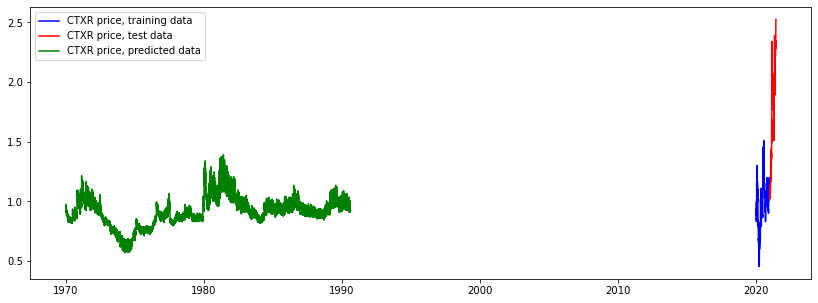

In [29]:
plt.figure(figsize=(14,5))
plt.plot(training_data[symbol], color='blue', label=f"{symbol} price, training data")
plt.plot(test_data[symbol], color='red', label=f"{symbol} price, test data")
plt.plot(predicted[f"{symbol}"], color='green', label=f"{symbol} price, predicted data")
plt.legend()

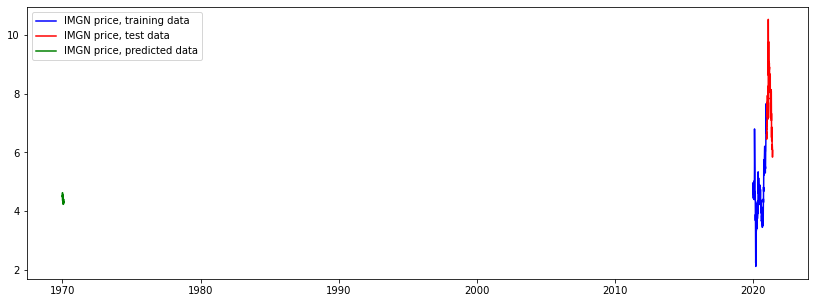

In [40]:
plt.figure(figsize=(14,5))
plt.plot(training_data[symbol], color='blue', label=f"{symbol} price, training data")
plt.plot(test_data[symbol], color='red', label=f"{symbol} price, test data")
plt.plot(predicted[f"{symbol}"], color='green', label=f"{symbol} price, predicted data")
plt.legend()